In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px

from classBanditsDynamic import Bandits

In [78]:
import classBanditsKalman
classBanditsKalman.Bandits

classBanditsKalman.Bandits

Replicating the experiment conducted by Daw et.al. (2006): https://www.nature.com/articles/nature04766#Sec3

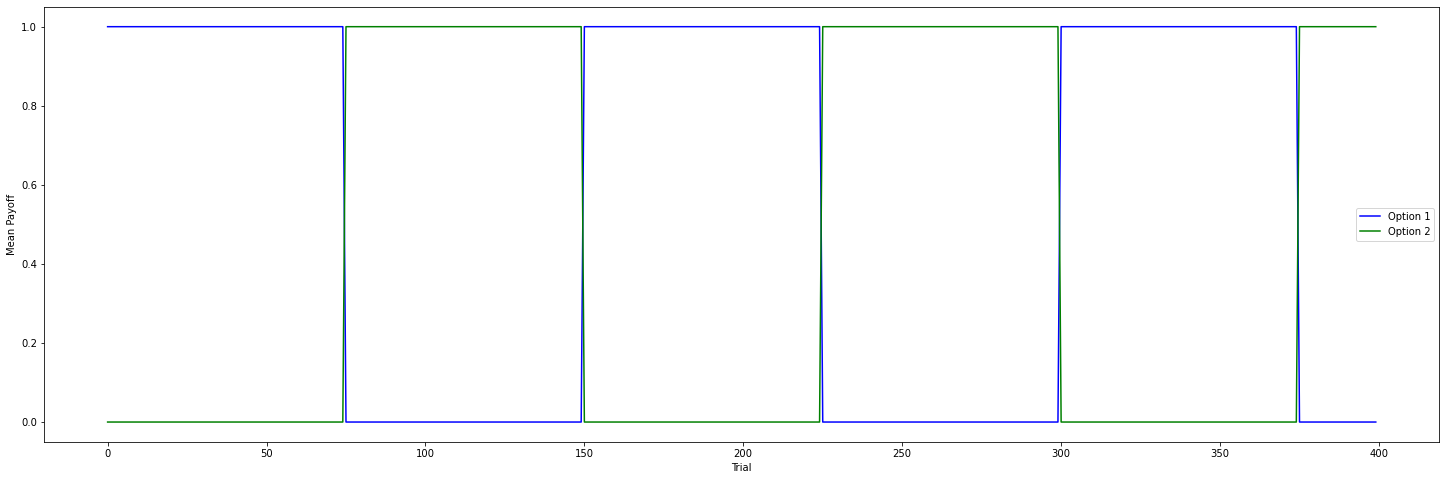

In [2]:
''' Initialising simulation class from loaded payoff function, calculating optimal solution, and printing loaded payoff function'''
payoffs = np.genfromtxt('payoffs/payoffs_switching.csv',delimiter=',')

total_time = len(payoffs[0,:])
simu = Bandits(total_time)
[_, optimal_scores,_] = simu.findRegret(payoffs,0)
simu.options = len(payoffs)

# Plotting payoff distribution with 1 SD error range + optimal picking overlaid
fig,ax = plt.subplots(figsize=(25,8))
colors = ['blue','green','red','orange']
for i in range(len(payoffs)):
    plt.plot(range(total_time),payoffs[i,:], color=colors[i], label='Option '+str(i+1))                
    # plt.fill_between(range(total_time),payoffs[i,:]-simu.sigma, payoffs[i,:]+simu.sigma,color=colors[i],alpha=0.1)
# plt.plot(range(total_time),optimal_scores,linewidth=1, color='black', label='Optimal')        # Plotting optimal score

plt.xlabel('Trial')
plt.ylabel('Mean Payoff')
# plt.ylim([0,100])
plt.legend()
plt.show()

In [ ]:
''' Stepped reward function generation  '''
# Change to random switching, similar to the novelty case

def rect(T):
    """create a centered rectangular pulse of width $T"""
    return lambda t: (-T/2 <= t) & (t < T/2)

def pulse_train(t, at, shape):
    """create a train of pulses over $t at times $at and shape $shape"""
    return np.sum(shape(t - at[:,np.newaxis]), axis=0)

sig1 = pulse_train(
    t=np.arange(500),              # time domain
    at=np.array([0, 100, 200, 350, 400]),  # times of pulses
    shape=rect(50)                 # shape of pulse
)

sig2 = -sig1+1

plt.plot(sig1)
plt.plot(sig2)

payoffs = np.array([sig1,sig2])
np.savetxt('payoffs\payoffs_switching_irregular.csv',payoffs,delimiter=',')



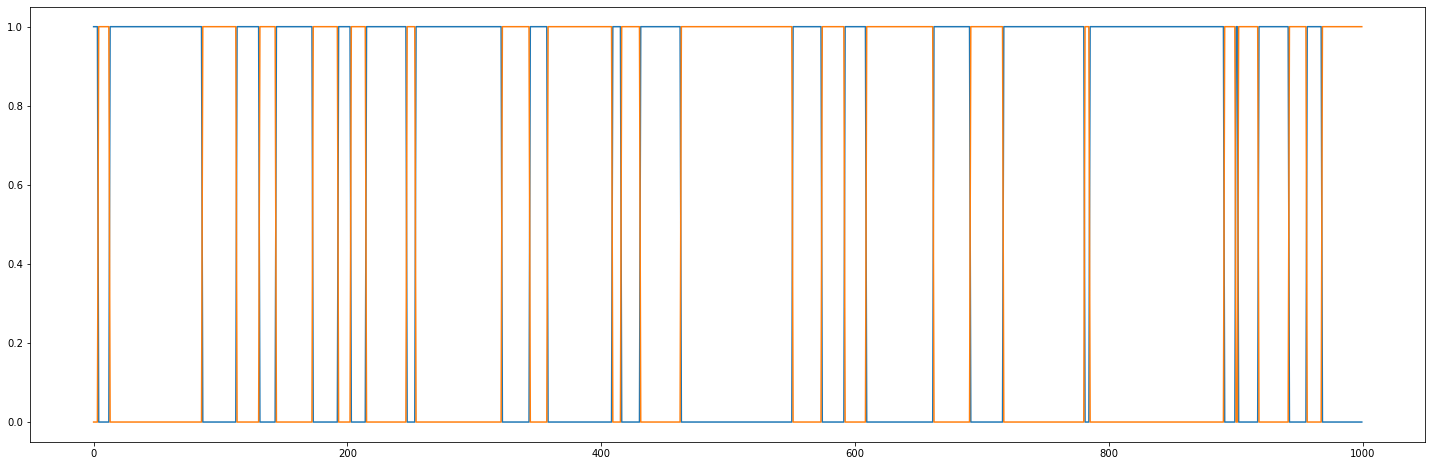

In [38]:
''' Random stepped reward function generation'''
from numpy import random

p_switch = 1-1/25        # Probability of an option switching at any given timestep

payoffs = np.zeros([2,1000])
payoffs[:,0] = [1,0]
# switches = np.zeros([2,20])

for step in range(1,1000):
    opt1 = 1
    if (p_switch < random.random()):
        payoffs[0,step],payoffs[1,step] = payoffs[1,step-1],payoffs[0,step-1]
    else:
        payoffs[0,step],payoffs[1,step] = payoffs[0,step-1],payoffs[1,step-1]

fig,ax = plt.subplots(figsize=(25,8))
plt.plot(payoffs[0,:])
plt.plot(payoffs[1,:])
plt.show()


In [39]:
np.savetxt('payoffs\payoffs_randstep.csv',payoffs,delimiter=',')

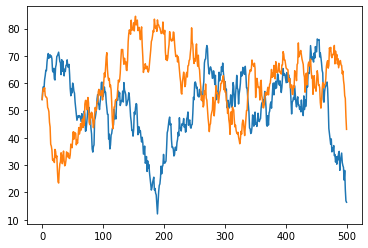

In [45]:
''' Restless reward function generation '''

simu = Bandits(500)
simu.options = 2
# simu.decay_centre = 50
# simu.decay_noise = 10

payoffs = simu.genMeans(10,50)

plt.plot(payoffs[0,:])
plt.plot(payoffs[1,:])

np.savetxt('payoffs\payoffs_2restlessA.csv',payoffs,delimiter=',')

In [ ]:
''' Novel options reward generation '''
# 3 options, each option has some chance of substitution at each step.
# Pick new static payoff from some available distribution of rewards.
# Store switching points in separate array w/ time + option swapped.
# Make sure there aren't any switches in the first 3 trials.

from numpy import random

possible_payoffs = random.normal(6,2,[3,500])         # Preallocate possible random values
p_switch = 0.995         # Probability of an option switching at any given timestep

payoffs = np.zeros([3,500])
payoffs[:,0] = possible_payoffs[:,0]
switches = np.zeros([2,20])

switch_counter = 0
for step in range(1,500):
    for option in range(3):
        if (p_switch < random.random()): 
            payoffs[option,step] = possible_payoffs[option,step]
            switches[0,switch_counter] = step
            switches[1,switch_counter] = option
            switch_counter += 1
        else:
            payoffs[option,step] = payoffs[option,step-1]


fig,ax = plt.subplots(figsize=(25,8))
plt.plot(payoffs[0,:])
plt.plot(payoffs[1,:])
plt.plot(payoffs[2,:])
plt.show()



In [148]:
np.savetxt('payoffs\payoffs_novel.csv',payoffs,delimiter=',')
np.savetxt('payoffs\switching_novel.csv',switches,delimiter=',')

In [113]:
''' Simulating trials with the loaded payoff function for the strategies: pure exploitation, discounted softmax, discounted UCB1.
    The optimal sampling proportion from each of the options is also shown, and compared to with the proportions sampled by the softmax and UCB algorithms.'''

exploit_reward = simu.exploit(payoffs,1000)
[exploit_regret, _, optimal_choices] = simu.findRegret(payoffs,exploit_reward)
print('Pure exploit Mean Regret: %s'% np.mean(exploit_regret),', Std: %s'% np.std(exploit_regret))
unique, counts = np.unique(optimal_choices, return_counts = True)
print('Proportions sampled (optimal):   ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')

# PAYOFF 1 PARMAS: 1, 0.995
# PAYOFF 4 PARAMS: 3.55, 0.99
# STEP 1 PARAMS: 1.6, 0.99
# STEP 2 PARAMS: 3, 0.97
softmax_scores, softmax_choices,softmax_history = simu.softmax(payoffs,1,0.97,100)
[softmax_regret, _, _] = simu.findRegret(payoffs,np.sum(softmax_scores,1))
print('Pure Softmax Mean Regret: %s'% np.mean(softmax_regret),', Std: %s'% np.std(softmax_regret))
unique, counts = np.unique(softmax_choices, return_counts = True)
print('Proportions sampled (softmax):   ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')

# PAYOFF 1 PARAMS: 1, 0.995
# PAYOFF 4 PARAMS: 4.6, 0.99
# STEP 1 PARAMS: 2.3, 0.99
# STEP 2 PARAMS: 3, 0.96
dUCB_scores, dUCB_choices,dUCB_history = simu.dUCB1(payoffs,5,0.98,100)
[dUCB_regret, _, _] = simu.findRegret(payoffs,np.sum(dUCB_scores,1))
print('Softmax + UCB Mean Regret: %s'% np.mean(dUCB_regret),', Std: %s'% np.std(dUCB_regret))
unique, counts = np.unique(dUCB_choices, return_counts = True)
print('Proportions sampled (softmax + IB):  ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')

Pure exploit Mean Regret: 0.17018775990122487 , Std: 0.003741870514478013
Proportions sampled (optimal):    blue: 0.75, green: 0.25

Pure Softmax Mean Regret: 0.14651766112893053 , Std: 0.020678607436882948
Proportions sampled (softmax):    blue: 0.59, green: 0.41

Softmax + UCB Mean Regret: 0.11865417061332316 , Std: 0.012280439576754851
Proportions sampled (softmax + IB):   blue: 0.6, green: 0.4



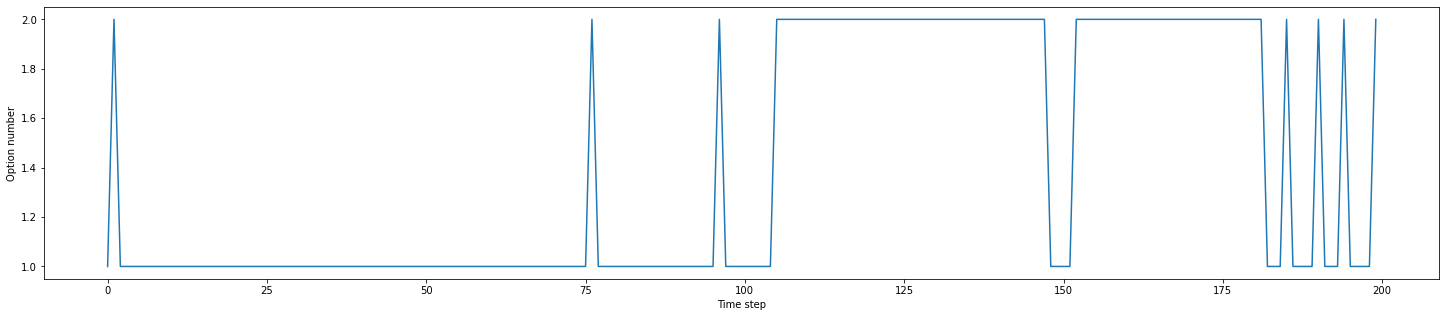

In [108]:
''' Plotting the choice history for one trial under the specific algorithm used. '''
fig,ax = plt.subplots(figsize=(25,5))
trial = 3
plt.plot(dUCB_choices[trial,:]+1) # getting into range 1,2,3,4
plt.xlabel('Time step')
plt.ylabel('Option number')
plt.show()

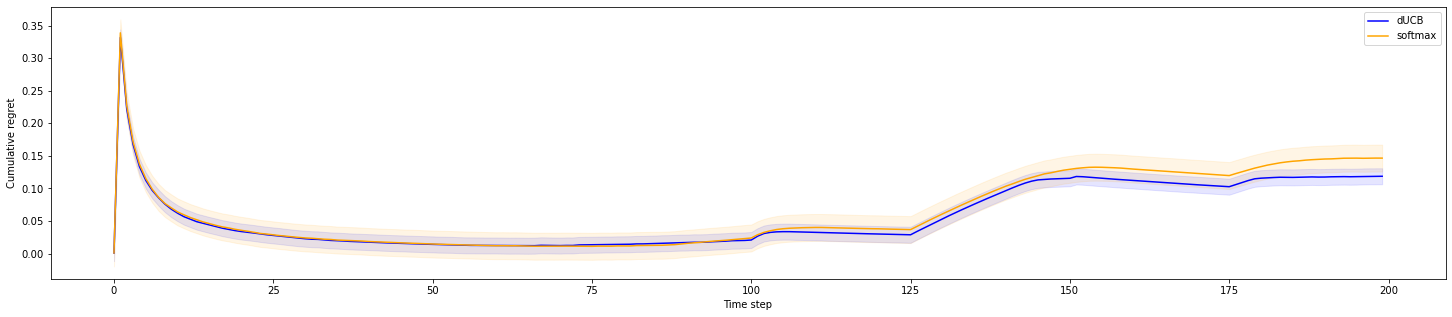

' Main issue: the dUCB + softmax and pure softmax algorithms have the same regret curve'

In [114]:
fig,ax = plt.subplots(figsize=(25,5))
trial = 1
optimal_cumu = np.cumsum(optimal_scores)
dUCB_scoresT = np.transpose(dUCB_scores)
softmax_scoresT = np.transpose(softmax_scores)

cRegret_ucb = 1-np.cumsum(np.mean(dUCB_scoresT,1))/optimal_cumu
cRegret_ucb_std = np.std(dUCB_regret)
plt.plot(cRegret_ucb,label='dUCB',color='blue')
plt.fill_between(range(total_time),cRegret_ucb-cRegret_ucb_std, cRegret_ucb+cRegret_ucb_std,color='blue',alpha=0.1)

cRegret_soft = 1-np.cumsum(np.mean(softmax_scoresT,1))/optimal_cumu
cRegret_soft_std = np.std(softmax_regret)
plt.plot(cRegret_soft,label='softmax',color='orange')
plt.fill_between(range(total_time),cRegret_soft-cRegret_soft_std, cRegret_soft+cRegret_soft_std,color='orange',alpha=0.1)



plt.legend()
plt.xlabel('Time step')
plt.ylabel('Cumulative regret')
plt.show()

''' Main issue: the dUCB + softmax and pure softmax algorithms have the same regret curve'''


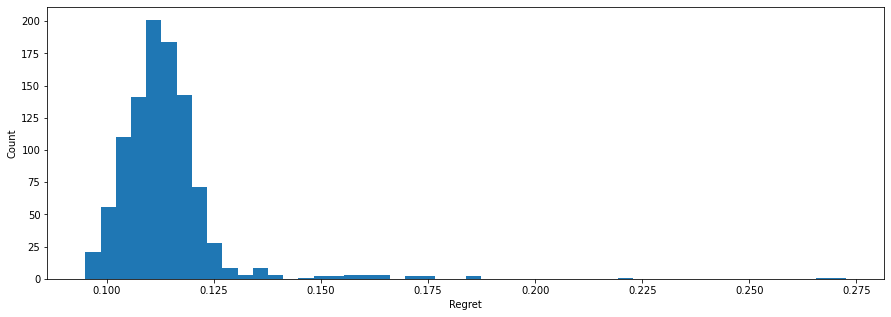

[0.11360687337391558, 0.11235687176665471]


In [9]:
''' Plotting the regret distribution over all the trials taken under a specific algorithm. '''
fig,ax = plt.subplots(figsize=(15,5))
plt.hist(dUCB_regret,50) 
plt.xlabel('Regret')
plt.ylabel('Count')
plt.show()
print([np.mean(dUCB_regret),np.median(dUCB_regret)])

In [206]:
''' Computing optimal parameters for each algorithm by looping over ranges'''
regret_list = np.zeros(10)
params = np.linspace(0.1,3,10)
for i in range(10):
    reward, choices,_ = simu.softmax(payoffs,params[i],0.98,100)
    [regret, _,_] = simu.findRegret(payoffs,reward)
    regret_list[i] = np.mean(regret)
optimal_temp = params[np.argmin(regret_list)]
print('Optimal temp: ', optimal_temp)
print('Softmax Mean Regret: %s'% regret_list[np.argmin(regret_list)]) # 3.2632: 0.1223


C:\Users\Evan Xie\AppData\Local\Temp\ipykernel_10116\1048155955.py:53: RuntimeWarning: overflow encountered in exp
  weights = np.exp(expected_rewards) / np.sum(np.exp(expected_rewards),1).reshape([trials,1])
C:\Users\Evan Xie\AppData\Local\Temp\ipykernel_10116\1048155955.py:53: RuntimeWarning: invalid value encountered in true_divide
  weights = np.exp(expected_rewards) / np.sum(np.exp(expected_rewards),1).reshape([trials,1])


Optimal temp:  3.0
Softmax Mean Regret: 0.23489829321547429


In [73]:
time,trials = 6,4

scores = np.zeros([trials,time])
# history = {idx:np.zeros([trials,self.time]) for idx in range(self.options)}       # History of priors: need this to be a single vector
history = np.zeros([trials,time,simu.options])
history_var = np.zeros([trials,time,simu.options])

for option in range(simu.options):
    scores[:,option] = simu.sample(np.zeros(trials) + payoffs[option,0])
    history_var[:,0,option] = np.zeros(trials) + 4
    history[:,0,option] = scores[:,option]
for t in range(1, time-simu.options+1):
    payoff_priors = history[:,t-1,:]
    weights = np.exp(payoff_priors) / np.sum(np.exp(payoff_priors),1).reshape([trials,1])
    chosen = (np.random.rand(len(weights),1) < weights.cumsum(axis=1)).argmax(axis=1)
    scores[:,t+simu.options-1] = simu.sample(payoffs[chosen,t])

    pred_err = scores[:,t+simu.options-1] - history[:,t-1,chosen]
    gain = history_var[:,t-1,chosen] / (history_var[:,t-1,chosen] + 4)
    post_mean = history_var[:,t-1,chosen] + gain*pred_err
    post_var = (1-gain)*history_var[:,t-1,chosen]
print(history_var[:,0,:])
print(chosen)
print(post_mean)
print(gain)

[[4. 4. 4.]
 [4. 4. 4.]
 [4. 4. 4.]
 [4. 4. 4.]]
[2 1 0 1]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [8]:
import numpy as np
import matplotlib.pyplot as plt

Z = np.array([0.17, 0.46, 0.59, 0.79, 1.09, 1.38, 1.72, 1.80, 2.12, 2.37, 2.57, 2.91, 3.04, 3.38, 3.58])
pi_z = np.array([3.15, 3.03, 3.49, 3.02, 3.31, 2.73, 3.39, 2.92, 2.98, 2.78, 2.51, 1.94, 3.03, 2.67, 2.31])

# Constants
sigma = 0.45
delta = 0.2
N = Z.shape[0]
pi0 = np.pi

log_likelihood = -N*np.log(sigma*np.sqrt(2*pi0)) - (1/(2*sigma**2))*sum((pi_z-pi0)**2)
likelihood0 = np.exp(log_likelihood)
print(f"{likelihood0:.4e}")

const = (sigma*np.sqrt(2*pi0))**(-N) / (delta*np.sqrt(2*pi0))
c0 = -1/(2*sigma**2) * sum((pi_z-pi0)**2)
c1 = sigma**(-2) * sum((pi_z-pi0)*Z)
c2 = -1/(2*delta**2) - 1/(2*sigma**2) * sum(Z**2)

likelihood1 = const * np.sqrt(-pi0/c2) * np.exp(c0 - c1**2/(4*c2))
print(f'{likelihood1:.4e}')


print(likelihood1/(likelihood1+likelihood0))

3.8679e-05
8.3845e-04
0.9559028049658388
